In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os
from scipy.linalg import block_diag, solve_discrete_are
from PO.utils import make_diagonalizable_matrix, make_positive_semidefinite, plot_loss, plot_loss_sliding, compare_losses, make_diagonalizable_matrix_complex, get_hankel_new, run_multiple_runs, run_multiple_controllers,  plot_runs_with_mean, plot_multiple_controllers, plot_multiple_sliding_losses, run_multiple_models_with_params, plot_loss_comparison, plot_loss_comparison_with_ci


from PO.LQG.lqg import LQG  # new updated
from PO.GRC.grc_final import GRC # new updated
from PO.GRC.grc_STU import GRC_STU # new updated

from PO.DSC.dsc import DSC # new updated (changed after algo change)
from PO.DSC.dsc_PO_STU import DSC_PO_STU # new updated

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

/Users/sofiiadruchyna/Desktop/spectral_control/PO/LQG/lqg.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q = torch.tensor(Q, dtype=torch.float32, device=self.device)


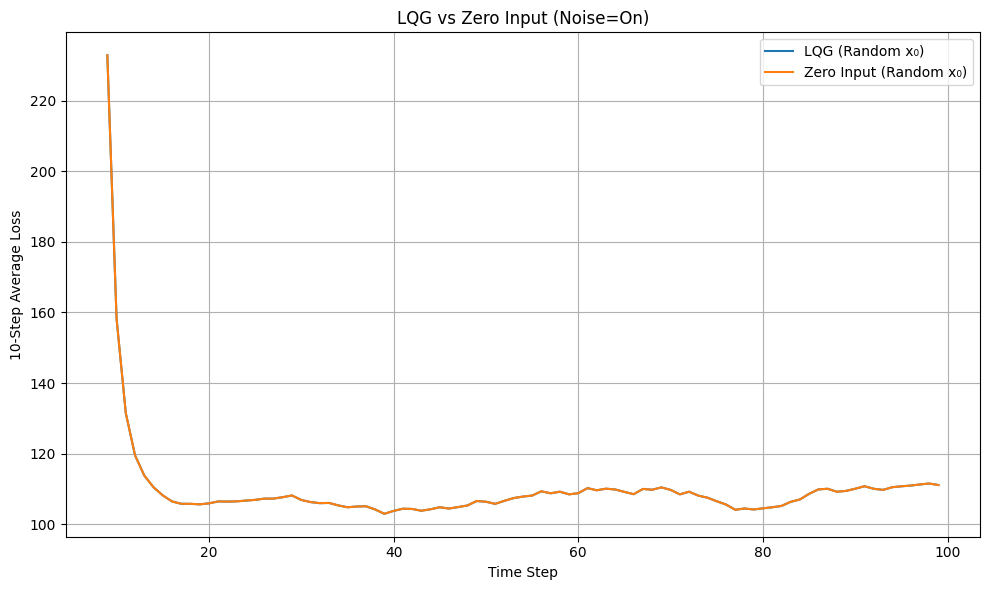

In [7]:
if __name__ == "__main__":
    # === CONFIGURATION ===
    torch.manual_seed(42)
    d = 30  # hidden state dimension
    p = 25  # observation dimension @ 25
    n = 5   # control dimension @ 5

    T = 100  # time horizon
    window = 10  # moving average window
    num_trials = 100
    add_noise = True  # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # === COST MATRICES ===
    Q = torch.eye(d, device=device)
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-5
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)
    
    # Convert matrices to CPU numpy arrays for LQG initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_np = Q.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np,T=T)
    
    controller_device = lqg_controller.device
    
    # Run simulations
    # With control
    lqg_costs = lqg_controller.run(
        initial_state=torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
    # Without control
    zero_costs = lqg_controller.run(
        initial_state=torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device),
        add_noise=add_noise,
        use_control=False,
        num_trials=num_trials
    )
    
    # Create a temporary controller to hold zero costs for plotting
    zero_controller = LQG(
        A=A_np,
        B=B_np,
        C=C_np,
        Q=Q,
        Q_obs=Q_obs_np,
        R=R_np,
        Q_noise=W_np,
        R_noise=V_np,
        T=T
    )
    zero_controller.losses = zero_costs
    
    # Plot results
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'
    
    # Option to plot both LQG and Zero Input
    
    plot_loss_comparison(
        [lqg_controller, zero_controller],
        [f'LQG ({label(random_initial_state)})', f'Zero Input ({label(random_initial_state)})'],
        f"LQG vs Zero Input (Noise={'On' if add_noise else 'Off'})",
        window_size=window
    )
    
    
    # Plot just LQG performance
    # plot_loss_comparison(
    #     [lqg_controller],
    #     [f'LQG ({label(random_initial_state)})'],
    #     f"LQG",
    #     window_size=window
    # )

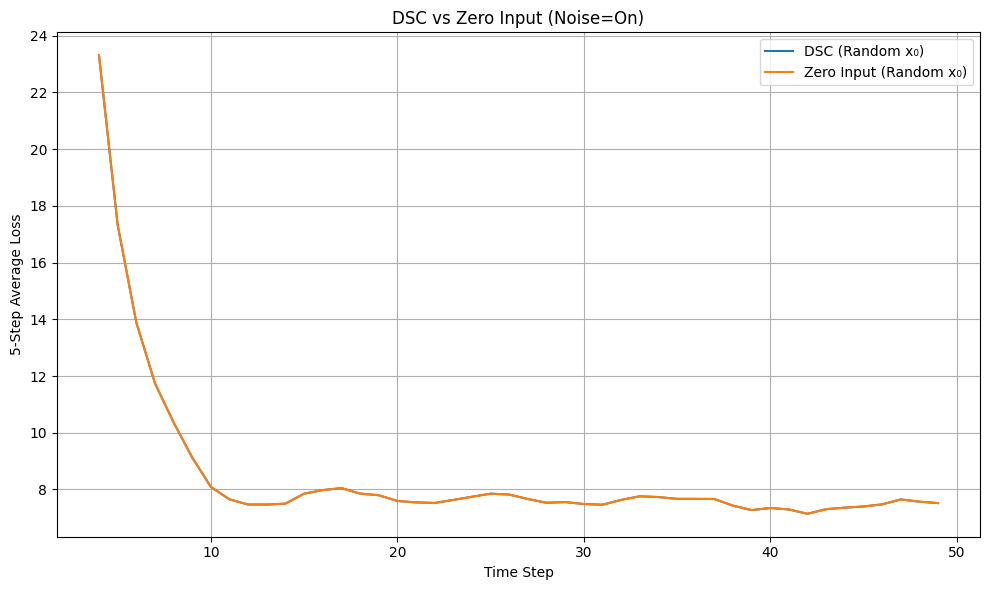

In [12]:
# FOR DSC TESTING

if __name__ == "__main__":
    # === CONFIGURATION ===
    torch.manual_seed(42)
    d = 10  # hidden state dimension
    p = 5  # observation dimension @ 25
    n = 2   # control dimension @ 5
    T = 50  # time horizon
    window = 5  # moving average window
    num_trials = 100
    add_noise = True  # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # MEMORY
    h = 5
    h_tilde = h
    m = 10
    m_tilde = m
    gamma = 0.1
    
    # === COST MATRICES ===
    Q = torch.eye(d, device=device)
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-5
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)
    
    # Convert matrices to CPU numpy arrays for LQG initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_np = Q.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    dsc_controller = DSC(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, h=h, h_tilde=h_tilde, m=m, m_tilde=m_tilde, gamma=gamma, Q_noise=W_np, R_noise=V_np,T=T)
    
    controller_device = dsc_controller.device
    
    # Run simulations
    # With control
    dsc_costs = dsc_controller.run(
        initial_state=torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device),
        add_noise=add_noise,
        use_control=False,
        num_trials=num_trials
    )
    dsc_controller.losses = dsc_costs
    
    # Without control
    zero_costs = dsc_controller.run(
        initial_state=torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device),
        add_noise=add_noise,
        use_control=False,
        num_trials=num_trials
    )
    
    # Create a temporary controller to hold zero costs for plotting
    zero_controller = DSC(
        A=A_np,
        B=B_np,
        C=C_np,
        Q=Q,
        Q_obs=Q_obs_np,
        R=R_np,
        h=h,
        h_tilde=h_tilde,
        m=m,
        m_tilde= m_tilde,
        gamma=gamma,
        Q_noise=W_np,
        R_noise=V_np,
        T=T
        )
    zero_controller.losses = zero_costs
    
    # Plot results
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'
    
    # Option to plot both LQG and Zero Input
    
    plot_loss_comparison(
        [dsc_controller, zero_controller],
        [f'DSC ({label(random_initial_state)})', f'Zero Input ({label(random_initial_state)})'],
        f"DSC vs Zero Input (Noise={'On' if add_noise else 'Off'})",
        window_size=window
    )
    

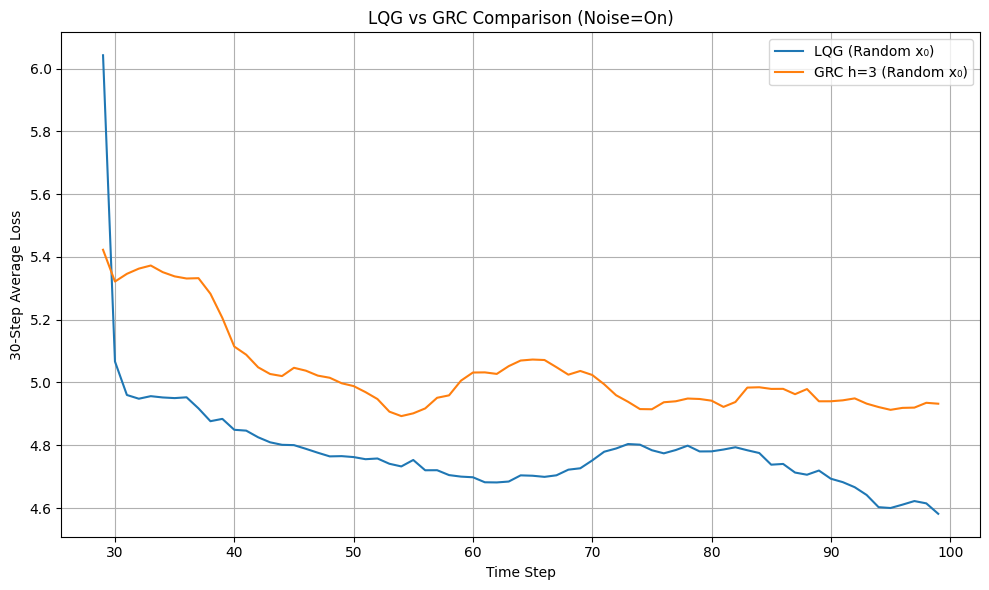

In [ ]:
if __name__ == "__main__":
    #=== CONFIGURATION ===
    torch.manual_seed(42)
    d = 10  # hidden state dimension
    p = 3  # observation dimension
    n = 2   # control dimension
    T = 100  # time horizon
    window = 30  # moving average window
    num_trials = 100
    add_noise = True   # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # GRC parameters
    h = 3  # history length
    lr = 0.01  # learning rate
    
    # === COST MATRICES ===
    Q = torch.eye(d, device=device)
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-1
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)
    
    
    # Convert matrices to CPU numpy arrays for controller initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_np = Q.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np,T=T)
    
    # Create GRC controller with same system matrices
    grc_controller = GRC(A=A_np, B=B_np,C=C_np,Q=Q_np,  Q_obs=Q_obs_np, R=R_np,Q_noise=W_np,R_noise=V_np,h=h,T=T,lr=lr)
    
    # Ensure initial state is on the correct device and the same for both controllers
    controller_device = lqg_controller.device
    initial_state = torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device)
    
    print(f"Running LQG controller with {'random' if random_initial_state else 'zero'} initial state")
    print(f"Process noise: {'On' if add_noise else 'Off'}")
    
    # Run LQG simulation with control
    lqg_costs = lqg_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
    print(f"Running GRC controller with h={h}, lr={lr}")
    
    # Run GRC simulation with same initial state
    grc_costs = grc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    grc_controller.losses = grc_costs
     
    # Create the labels
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'

    plot_loss_comparison(
        [grc_controller],
        [ 
         f'GRC h={h} ({label(random_initial_state)})'],
        f"LQG vs GRC Comparison (Noise={'On' if add_noise else 'Off'})",
        window_size=window #save_path="PO/figures/results/grc_v_lqg_new_gauss_30_25_5.png"
    )

    
    # Plot just LQG vs GRC for clearer comparison
    plot_loss_comparison(
        [lqg_controller, grc_controller],
        [f'LQG ({label(random_initial_state)})', 
            f'GRC h={h} ({label(random_initial_state)})'],
        f"LQG vs GRC Comparison (Noise={'On' if add_noise else 'Off'})",
        window_size=window, save_path="PO/figures/results/grc_v_lqg_new_gauss_10_3_2_wind30.png"
    )

Running LQG controller with random initial state
Process noise: On
Running GRC controller with h=3, lr=0.01
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HE

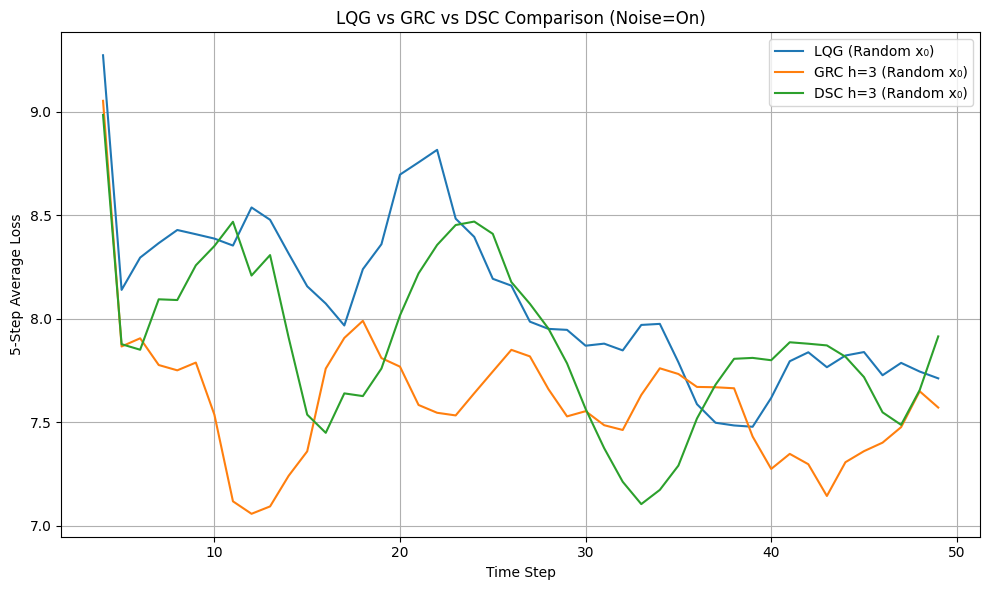

In [68]:
if __name__ == "__main__":
    # === CONFIGURATION ===
    torch.manual_seed(42)
    d = 10  # hidden state dimension
    p = 5  # observation dimension
    n = 2   # control dimension
    T = 50  # time horizon
    window = 5  # moving average window
    num_trials = 100
    add_noise = True  # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # GRC parameters
    h = 3  # history length
    lr = 0.01  # learning rate
    
    # === COST MATRICES ===
    Q = torch.eye(d, device=device)
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-1
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)

    
    # Convert matrices to CPU numpy arrays for controller initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_np = Q.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np,T=T)
    
    # Create GRC controller with same system matrices
    grc_controller = GRC(A=A_np, B=B_np,C=C_np,Q=Q_np,  Q_obs=Q_obs_np, R=R_np,Q_noise=W_np,R_noise=V_np,h=h,T=T,lr=lr)

    # Create DSC controller with same system matrices
    dsc_controller = DSC(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, h=h, h_tilde=h_tilde, m=m, m_tilde=m_tilde, gamma=gamma, Q_noise=W_np, R_noise=V_np,T=T)
    
    # Ensure initial state is on the correct device and the same for both controllers
    controller_device = lqg_controller.device
    initial_state = torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device)
    
    print(f"Running LQG controller with {'random' if random_initial_state else 'zero'} initial state")
    print(f"Process noise: {'On' if add_noise else 'Off'}")
    
    # Run LQG simulation with control
    lqg_costs = lqg_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=False,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
    print(f"Running GRC controller with h={h}, lr={lr}")
    
    # Run GRC simulation with same initial state
    grc_costs = grc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=False,
        num_trials=num_trials
    )
    grc_controller.losses = grc_costs
     
    # Create the labels
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'

    # Run GRC simulation with same initial state
    dsc_costs = dsc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=False,
        num_trials=num_trials
    )
    dsc_controller.losses = dsc_costs
     
    # Create the labels
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'

    
    # Plot just LQG vs GRC for clearer comparison
    plot_loss_comparison(
        [lqg_controller, grc_controller, dsc_controller],
        [f'LQG ({label(random_initial_state)})', 
         f'GRC h={h} ({label(random_initial_state)})', f'DSC h={h} ({label(random_initial_state)})'],
        f"LQG vs GRC vs DSC Comparison (Noise={'On' if add_noise else 'Off'})",
        window_size=window #save_path="PO/figures/results/grc_v_lqg_new_gauss_30_25_5.png"
    )

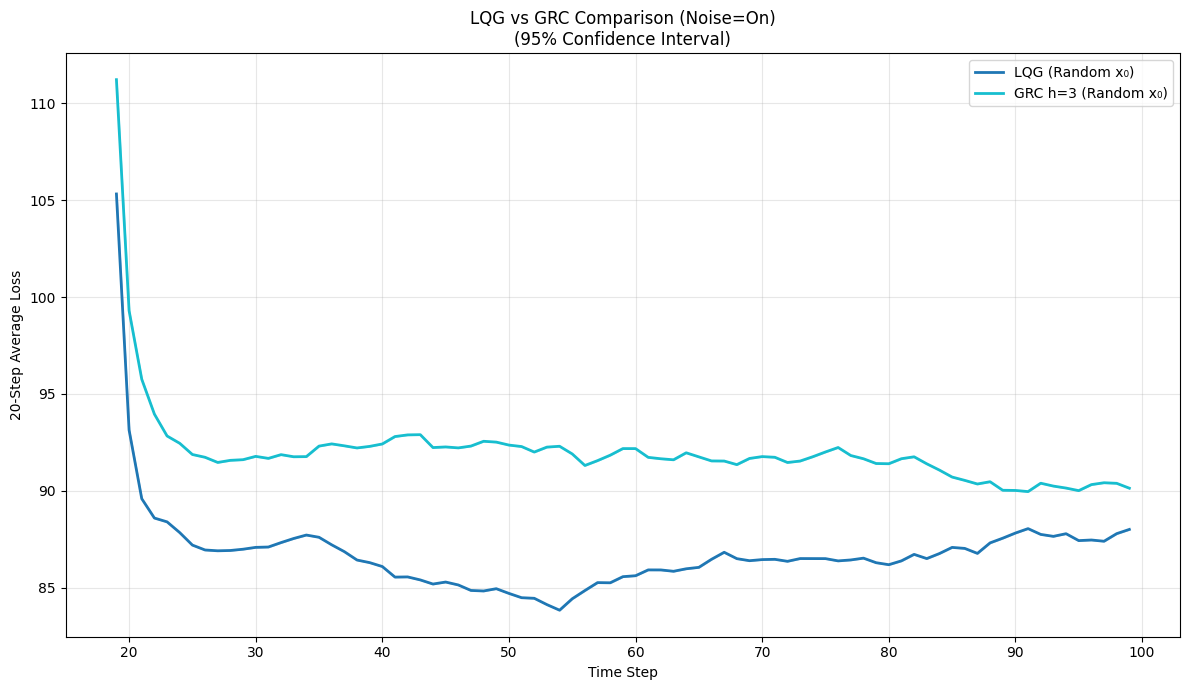

In [27]:
means, lowers, uppers = plot_loss_comparison_with_ci(
    [lqg_controller, grc_controller],
    [f'LQG ({label(random_initial_state)})', f'GRC h={h} ({label(random_initial_state)})'],
    f"LQG vs GRC Comparison (Noise={'On' if add_noise else 'Off'})",
    window_size=20,
    confidence=0.95
)
mean_lqg, mean_grc = means
lower_lqg, lower_grc = lowers
upper_lqg, upper_grc = uppers